In [1]:
from diagonal_bilstm import DiagonalBiLSTM
from flax import nnx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import treescope
import keras
import tqdm
treescope.register_as_default()

2025-08-03 19:29:55.722285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 19:29:55.733933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 19:29:55.737367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: apoorvreddy to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
def display_image_grid(images, grid_shape):
    assert images.shape[0] == grid_shape[0] * grid_shape[1]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=grid_shape)
    fig.patch.set_facecolor('black') # Set background to black for better contrast
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        img_to_show = images[i]
        ax.imshow(img_to_show, cmap='gray')
        ax.axis('off') # Hide the x and y axes
    plt.show()

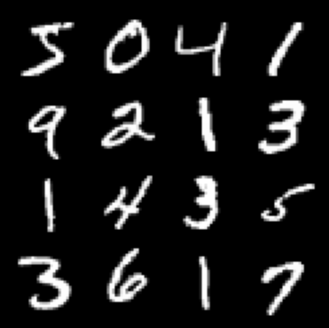

In [5]:
display_image_grid(x_train[:16], (4, 4))


In [6]:
class Batcher:
    def __init__(self, images, batch_size, binarize: bool = False):
        self.images = images
        self.bsz = batch_size
        self.iter = 0
        self.binarize = binarize
    
    def get_batch(self):
        if (self.iter + 1) * self.bsz < self.images.shape[0]:
            start_idx = self.iter * self.bsz
            end_idx = (self.iter + 1) * self.bsz
            self.iter += 1
            batch = (self.images[start_idx: end_idx][..., jnp.newaxis])
            if self.binarize:
                return batch/256.0 > 0.5
            return batch
        else:
            self.shuffle()
            return self.get_batch()
    
    def shuffle(self):
        np.random.shuffle(self.images)
        self.iter = 0

In [7]:
def compute_nll(logits_bmnd, im_bmnc):
    # compute negative log-likelihood of a batch
    logprob_bmnd = nnx.log_softmax(logits_bmnd)
    logprob_bmn = logprob_bmnd[im_bmnc[:,:,:,0]]
    return -jnp.mean(jnp.sum(logprob_bmn, axis=[1, 2]))

def compute_loss(model, image_batch, binarize):
    logits = model(image_batch)
    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        loss = jnp.mean(loss)
    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)
    return loss

def compute_metrics(model, image_batch, binarize):
    logits = model(image_batch)

    if binarize:
        labels = image_batch
        loss = optax.sigmoid_binary_cross_entropy(logits, labels)
        nll = jnp.mean(jnp.sum(loss, axis=[1, 2]))
        loss = jnp.mean(loss)

        top1_accuracy = ((logits > 0).astype(jnp.int8) == image_batch)
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))

    else:
        labels = nnx.one_hot(image_batch[:,:,:,0], 256)
        loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
        loss = jnp.mean(loss)

        top1_accuracy = (jnp.argmax(logits) == image_batch[:,:,:,0])
        top1_accuracy = jnp.mean(jnp.mean(top1_accuracy, axis=[1, 2]))
    
        nll = compute_nll(logits, image_batch, binarize)

    return loss, top1_accuracy, nll


@nnx.jit(static_argnames=['binarize'])
def train_step(model, optimizer, batch, binarize):
    grad_fn = nnx.value_and_grad(compute_loss)
    loss, grads = grad_fn(model, batch, binarize)
    optimizer.update(grads)
    return loss

@nnx.jit(static_argnames=['binarize'])
def eval_step(model, batch, eval_metrics, binarize):
    loss, top1_accuracy, nll = compute_metrics(model, batch, binarize)

    eval_metrics.update(
        loss=loss,
        accuracy=top1_accuracy,
        nll=nll
    )

In [8]:
def count_params(model):
    params = nnx.state(model, nnx.Param)
    total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(params))
    print(total_params)

    for path, x in jax.tree_util.tree_leaves_with_path(params):
        print(path, np.prod(x.shape))
    return total_params

## Overfit to one image

In [9]:
# batcher = Batcher(x_train, 1, binarize=True)
# batch = batcher.get_batch()

# plt.figure(figsize=(1, 1))
# plt.imshow(batch[0], cmap='gray')

# rngs = nnx.Rngs(params=0)

# features=16
# output_conv_out_channels = [32, 32]
# num_layers = 1
# preds_dim = 1

# model = DiagonalBiLSTM(features=features,
#                 num_layers=num_layers,
#                 output_conv_out_channels=output_conv_out_channels,
#                 preds_dim=1,
#                 rngs=rngs)
# num_params = count_params(model)
# optimizer = nnx.Optimizer(model, optax.rmsprop(
#     learning_rate=1e-3,
# ))


In [10]:
# for i in range(200):
#     loss = train_step(model, optimizer, batch, binarize=True)
#     print(f"loss[{i}]: {loss}")

In [11]:
# gen_image_batch = model.generate(28, 28, 4, jax.random.key(2))
# display_image_grid(gen_image_batch[:,:,:,0], (2, 2))

## Train on entire MNIST dataset.

In [12]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
batch_size = 64
train_total_steps = x_train.shape[0] // batch_size
num_epochs = 100
eval_total_steps = x_test.shape[0] // batch_size
binarize = True


eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Average('accuracy'),
    nll=nnx.metrics.Average('nll')
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
    "test_nll": []
}

def train_one_epoch(epoch, model, optimizer, binarize):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        batcher = Batcher(x_train, batch_size, binarize)
        batcher.shuffle()
        for i in range(train_total_steps):
            batch = batcher.get_batch()
            loss = train_step(model, optimizer, batch, binarize)
            train_metrics_history["train_loss"].append(loss.item())
            wandb.log({"train_loss": loss.item(), "samples": epoch * train_total_steps * batch_size + (i+1) * batch_size})
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch, model, binarize):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics
    with tqdm.tqdm(
        desc=f"[eval] epoch: {epoch}/{num_epochs}, ",
        total=eval_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        eval_metrics.reset()  # Reset the eval metrics
        batcher = Batcher(x_test, batch_size, binarize)
        for i in range(eval_total_steps):
            batch = batcher.get_batch()
            eval_step(model, batch, eval_metrics, binarize)
            pbar.update(1)

        for metric, value in eval_metrics.compute().items():
            wandb.log({f'test_{metric}': value})
            eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[eval] epoch: {epoch}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")
    print(f"- NLL: {eval_metrics_history['test_nll'][-1]:0.4f}")

In [13]:
#@title Training Config

# data

rngs = nnx.Rngs(params=0)
# model
features=16
output_conv_out_channels = [32, 32]
num_layers = 7
preds_dim = 1 if binarize else 256
enable_skip_connections = True

#lr_scheduler
lr_init_value=1e-7
lr_peak_value=1e-3
lr_decay_steps=num_epochs * train_total_steps
lr_warmup_steps=max(lr_decay_steps * 0.01, 1000)

#optimizer
grad_clip = 1.0

run = wandb.init(
    project="pixel-rnn-mnist",  # Specify your project
    config={                        # Track hyperparameters and metadata
        "lr_scheduler": {
            # 'init_value': lr_init_value,
            'peak_value': lr_peak_value,
            # 'warmup_steps': lr_warmup_steps,
            # 'decay_steps': lr_decay_steps
        },
        "model": {
            "features": features,
            "input_conv_kernel": (7, 7),
            "output_conv_channels": output_conv_out_channels,
            "residual_connections": True,
            "num_layers": num_layers,
            "learned_hidden_init": True,
            "enable_skip_connections": enable_skip_connections,
            "preds_dim": preds_dim
        },
        "training": {
            "batch_size": batch_size,
            "epochs": num_epochs,
            "binarize": binarize
        },
        "optimizer": {
            "name": "adam",
            "grad_clip": grad_clip,
        },
        "architecture": "diagonal-bilstm"
    },
)

wandb.define_metric("train_loss", step_metric="samples")
wandb.define_metric("test_nll", step_metric="samples")
wandb.define_metric("test_accuracy", step_metric="samples")
wandb.define_metric("test_loss", step_metric="samples")

In [14]:
model = DiagonalBiLSTM(features=features,
                num_layers=num_layers,
                output_conv_out_channels=output_conv_out_channels,
                enable_skip_connections=enable_skip_connections,
                preds_dim=preds_dim,
                rngs=rngs)
# lr_scheduler = optax.warmup_cosine_decay_schedule(
#     init_value=lr_init_value,
#     peak_value=lr_peak_value,
#     warmup_steps=lr_warmup_steps,
#     decay_steps=lr_decay_steps
# )

optimizer = nnx.Optimizer(
    model,
    optax.chain(
        optax.clip_by_global_norm(grad_clip),
        optax.adam(learning_rate=lr_peak_value)
    )
)
# optimizer = nnx.Optimizer(model, optax.rmsprop(lr_scheduler))
count_params(model)

71617
(DictKey(key='head'), DictKey(key='bias'), GetAttrKey(name='value')) 1
(DictKey(key='head'), DictKey(key='kernel'), GetAttrKey(name='value')) 32
(DictKey(key='input_conv'), DictKey(key='bias'), GetAttrKey(name='value')) 32
(DictKey(key='input_conv'), DictKey(key='kernel'), GetAttrKey(name='value')) 1568
(DictKey(key='layers'), DictKey(key=0), DictKey(key='left_layer'), DictKey(key='diagonal_lstm'), DictKey(key='is_kernel'), DictKey(key='bias'), GetAttrKey(name='value')) 64
(DictKey(key='layers'), DictKey(key=0), DictKey(key='left_layer'), DictKey(key='diagonal_lstm'), DictKey(key='is_kernel'), DictKey(key='kernel'), GetAttrKey(name='value')) 2048
(DictKey(key='layers'), DictKey(key=0), DictKey(key='left_layer'), DictKey(key='diagonal_lstm'), DictKey(key='ln'), DictKey(key='bias'), GetAttrKey(name='value')) 32
(DictKey(key='layers'), DictKey(key=0), DictKey(key='left_layer'), DictKey(key='diagonal_lstm'), DictKey(key='ln'), DictKey(key='scale'), GetAttrKey(name='value')) 32
(DictK

71617

In [15]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, optimizer, binarize)
    evaluate_model(epoch, model, binarize)

[train] epoch: 0/100, [937/937], loss=0.0829 [02:27<00:00]
[eval] epoch: 0/100, [156/156] [00:07<00:00]


[eval] epoch: 0/100
- total loss: 0.0876
- Accuracy: 0.9642
- NLL: 68.6736


[train] epoch: 1/100, [937/937], loss=0.0855 [02:16<00:00]
[eval] epoch: 1/100, [156/156] [00:05<00:00]


[eval] epoch: 1/100
- total loss: 0.0827
- Accuracy: 0.9662
- NLL: 64.8323


[train] epoch: 2/100, [937/937], loss=0.0818 [02:15<00:00]
[eval] epoch: 2/100, [156/156] [00:05<00:00]


[eval] epoch: 2/100
- total loss: 0.0809
- Accuracy: 0.9668
- NLL: 63.4247


[train] epoch: 3/100, [937/937], loss=0.0813 [02:17<00:00]
[eval] epoch: 3/100, [156/156] [00:04<00:00]


[eval] epoch: 3/100
- total loss: 0.0793
- Accuracy: 0.9676
- NLL: 62.1563


[train] epoch: 4/100, [937/937], loss=0.0742 [02:15<00:00]
[eval] epoch: 4/100, [156/156] [00:05<00:00]


[eval] epoch: 4/100
- total loss: 0.0781
- Accuracy: 0.9680
- NLL: 61.2594


[train] epoch: 5/100, [937/937], loss=0.0759 [02:14<00:00]
[eval] epoch: 5/100, [156/156] [00:05<00:00]


[eval] epoch: 5/100
- total loss: 0.0780
- Accuracy: 0.9680
- NLL: 61.1182


[train] epoch: 6/100, [937/937], loss=0.0783 [02:12<00:00]
[eval] epoch: 6/100, [156/156] [00:05<00:00]


[eval] epoch: 6/100
- total loss: 0.0766
- Accuracy: 0.9687
- NLL: 60.0194


[train] epoch: 7/100, [937/937], loss=0.0809 [02:17<00:00]
[eval] epoch: 7/100, [156/156] [00:05<00:00]


[eval] epoch: 7/100
- total loss: 0.0762
- Accuracy: 0.9688
- NLL: 59.7142


[train] epoch: 8/100, [937/937], loss=0.0758 [02:16<00:00]
[eval] epoch: 8/100, [156/156] [00:05<00:00]


[eval] epoch: 8/100
- total loss: 0.0755
- Accuracy: 0.9691
- NLL: 59.2038


[train] epoch: 9/100, [937/937], loss=0.0756 [02:15<00:00]
[eval] epoch: 9/100, [156/156] [00:04<00:00]


[eval] epoch: 9/100
- total loss: 0.0763
- Accuracy: 0.9687
- NLL: 59.8240


[train] epoch: 10/100, [937/937], loss=0.0747 [02:16<00:00]
[eval] epoch: 10/100, [156/156] [00:05<00:00]


[eval] epoch: 10/100
- total loss: 0.0755
- Accuracy: 0.9691
- NLL: 59.1761


[train] epoch: 11/100, [937/937], loss=0.0777 [02:14<00:00]
[eval] epoch: 11/100, [156/156] [00:05<00:00]


[eval] epoch: 11/100
- total loss: 0.0754
- Accuracy: 0.9691
- NLL: 59.1362


[train] epoch: 12/100, [937/937], loss=0.0747 [02:16<00:00]
[eval] epoch: 12/100, [156/156] [00:04<00:00]


[eval] epoch: 12/100
- total loss: 0.0748
- Accuracy: 0.9694
- NLL: 58.6270


[train] epoch: 13/100, [937/937], loss=0.0795 [02:12<00:00]
[eval] epoch: 13/100, [156/156] [00:05<00:00]


[eval] epoch: 13/100
- total loss: 0.0744
- Accuracy: 0.9696
- NLL: 58.3249


[train] epoch: 14/100, [937/937], loss=0.0782 [02:11<00:00]
[eval] epoch: 14/100, [156/156] [00:05<00:00]


[eval] epoch: 14/100
- total loss: 0.0747
- Accuracy: 0.9695
- NLL: 58.5676


[train] epoch: 15/100, [937/937], loss=0.0769 [02:13<00:00]
[eval] epoch: 15/100, [156/156] [00:04<00:00]


[eval] epoch: 15/100
- total loss: 0.0741
- Accuracy: 0.9697
- NLL: 58.0709


[train] epoch: 16/100, [937/937], loss=0.0721 [02:14<00:00]
[eval] epoch: 16/100, [156/156] [00:05<00:00]


[eval] epoch: 16/100
- total loss: 0.0738
- Accuracy: 0.9698
- NLL: 57.8558


[train] epoch: 17/100, [937/937], loss=0.0718 [02:16<00:00]
[eval] epoch: 17/100, [156/156] [00:05<00:00]


[eval] epoch: 17/100
- total loss: 0.0736
- Accuracy: 0.9699
- NLL: 57.6980


[train] epoch: 18/100, [937/937], loss=0.0703 [02:12<00:00]
[eval] epoch: 18/100, [156/156] [00:04<00:00]


[eval] epoch: 18/100
- total loss: 0.0736
- Accuracy: 0.9699
- NLL: 57.6786


[train] epoch: 19/100, [937/937], loss=0.0771 [02:12<00:00]
[eval] epoch: 19/100, [156/156] [00:05<00:00]


[eval] epoch: 19/100
- total loss: 0.0734
- Accuracy: 0.9699
- NLL: 57.5560


[train] epoch: 20/100, [937/937], loss=0.0701 [02:13<00:00]
[eval] epoch: 20/100, [156/156] [00:05<00:00]


[eval] epoch: 20/100
- total loss: 0.0734
- Accuracy: 0.9699
- NLL: 57.5667


[train] epoch: 21/100, [937/937], loss=0.0747 [02:14<00:00]
[eval] epoch: 21/100, [156/156] [00:05<00:00]


[eval] epoch: 21/100
- total loss: 0.0735
- Accuracy: 0.9699
- NLL: 57.6565


[train] epoch: 22/100, [937/937], loss=0.0691 [02:17<00:00]
[eval] epoch: 22/100, [156/156] [00:05<00:00]


[eval] epoch: 22/100
- total loss: 0.0735
- Accuracy: 0.9699
- NLL: 57.6205


[train] epoch: 23/100, [937/937], loss=0.0738 [02:16<00:00]
[eval] epoch: 23/100, [156/156] [00:04<00:00]


[eval] epoch: 23/100
- total loss: 0.0731
- Accuracy: 0.9701
- NLL: 57.3181


[train] epoch: 24/100, [937/937], loss=0.0719 [02:16<00:00]
[eval] epoch: 24/100, [156/156] [00:04<00:00]


[eval] epoch: 24/100
- total loss: 0.0736
- Accuracy: 0.9698
- NLL: 57.6847


[train] epoch: 25/100, [937/937], loss=0.0744 [02:15<00:00]
[eval] epoch: 25/100, [156/156] [00:05<00:00]


[eval] epoch: 25/100
- total loss: 0.0728
- Accuracy: 0.9702
- NLL: 57.0608


[train] epoch: 26/100, [937/937], loss=0.0736 [02:11<00:00]
[eval] epoch: 26/100, [156/156] [00:05<00:00]


[eval] epoch: 26/100
- total loss: 0.0727
- Accuracy: 0.9702
- NLL: 56.9719


[train] epoch: 27/100, [937/937], loss=0.0739 [02:11<00:00]
[eval] epoch: 27/100, [156/156] [00:04<00:00]


[eval] epoch: 27/100
- total loss: 0.0726
- Accuracy: 0.9703
- NLL: 56.9180


[train] epoch: 28/100, [937/937], loss=0.07 [02:12<00:00]  
[eval] epoch: 28/100, [156/156] [00:05<00:00]


[eval] epoch: 28/100
- total loss: 0.0726
- Accuracy: 0.9703
- NLL: 56.9043


[train] epoch: 29/100, [937/937], loss=0.07 [02:11<00:00]  
[eval] epoch: 29/100, [156/156] [00:05<00:00]


[eval] epoch: 29/100
- total loss: 0.0726
- Accuracy: 0.9703
- NLL: 56.8946


[train] epoch: 30/100, [937/937], loss=0.0706 [02:13<00:00]
[eval] epoch: 30/100, [156/156] [00:04<00:00]


[eval] epoch: 30/100
- total loss: 0.0726
- Accuracy: 0.9703
- NLL: 56.9214


[train] epoch: 31/100, [937/937], loss=0.0713 [02:13<00:00]
[eval] epoch: 31/100, [156/156] [00:04<00:00]


[eval] epoch: 31/100
- total loss: 0.0725
- Accuracy: 0.9703
- NLL: 56.8311


[train] epoch: 32/100, [937/937], loss=0.0688 [02:12<00:00]
[eval] epoch: 32/100, [156/156] [00:04<00:00]


[eval] epoch: 32/100
- total loss: 0.0729
- Accuracy: 0.9701
- NLL: 57.1818


[train] epoch: 33/100, [937/937], loss=0.0692 [02:12<00:00]
[eval] epoch: 33/100, [156/156] [00:05<00:00]


[eval] epoch: 33/100
- total loss: 0.0722
- Accuracy: 0.9704
- NLL: 56.5765


[train] epoch: 34/100, [937/937], loss=0.0705 [02:12<00:00]
[eval] epoch: 34/100, [156/156] [00:05<00:00]


[eval] epoch: 34/100
- total loss: 0.0721
- Accuracy: 0.9704
- NLL: 56.5383


[train] epoch: 35/100, [937/937], loss=0.0745 [02:12<00:00]
[eval] epoch: 35/100, [156/156] [00:04<00:00]


[eval] epoch: 35/100
- total loss: 0.0726
- Accuracy: 0.9703
- NLL: 56.8952


[train] epoch: 36/100, [937/937], loss=0.074 [02:12<00:00] 
[eval] epoch: 36/100, [156/156] [00:05<00:00]


[eval] epoch: 36/100
- total loss: 0.0721
- Accuracy: 0.9705
- NLL: 56.5490


[train] epoch: 37/100, [937/937], loss=0.0717 [02:14<00:00]
[eval] epoch: 37/100, [156/156] [00:05<00:00]


[eval] epoch: 37/100
- total loss: 0.0720
- Accuracy: 0.9705
- NLL: 56.4795


[train] epoch: 38/100, [937/937], loss=0.0739 [02:17<00:00]
[eval] epoch: 38/100, [156/156] [00:05<00:00]


[eval] epoch: 38/100
- total loss: 0.0718
- Accuracy: 0.9706
- NLL: 56.3221


[train] epoch: 39/100, [937/937], loss=0.0731 [02:14<00:00]
[eval] epoch: 39/100, [156/156] [00:04<00:00]


[eval] epoch: 39/100
- total loss: 0.0725
- Accuracy: 0.9703
- NLL: 56.8696


[train] epoch: 40/100, [937/937], loss=0.0712 [02:12<00:00]
[eval] epoch: 40/100, [156/156] [00:04<00:00]


[eval] epoch: 40/100
- total loss: 0.0721
- Accuracy: 0.9705
- NLL: 56.5428


[train] epoch: 41/100, [937/937], loss=0.0676 [02:13<00:00]
[eval] epoch: 41/100, [156/156] [00:05<00:00]


[eval] epoch: 41/100
- total loss: 0.0719
- Accuracy: 0.9705
- NLL: 56.3836


[train] epoch: 42/100, [937/937], loss=0.0719 [02:12<00:00]
[eval] epoch: 42/100, [156/156] [00:05<00:00]


[eval] epoch: 42/100
- total loss: 0.0717
- Accuracy: 0.9706
- NLL: 56.1960


[train] epoch: 43/100, [937/937], loss=0.0708 [02:13<00:00]
[eval] epoch: 43/100, [156/156] [00:04<00:00]


[eval] epoch: 43/100
- total loss: 0.0720
- Accuracy: 0.9704
- NLL: 56.4575


[train] epoch: 44/100, [937/937], loss=0.0705 [02:16<00:00]
[eval] epoch: 44/100, [156/156] [00:05<00:00]


[eval] epoch: 44/100
- total loss: 0.0718
- Accuracy: 0.9706
- NLL: 56.2610


[train] epoch: 45/100, [937/937], loss=0.0716 [02:15<00:00]
[eval] epoch: 45/100, [156/156] [00:05<00:00]


[eval] epoch: 45/100
- total loss: 0.0715
- Accuracy: 0.9707
- NLL: 56.0689


[train] epoch: 46/100, [937/937], loss=0.07 [02:14<00:00]  
[eval] epoch: 46/100, [156/156] [00:05<00:00]


[eval] epoch: 46/100
- total loss: 0.0715
- Accuracy: 0.9707
- NLL: 56.0425


[train] epoch: 47/100, [937/937], loss=0.0746 [02:12<00:00]
[eval] epoch: 47/100, [156/156] [00:04<00:00]


[eval] epoch: 47/100
- total loss: 0.0715
- Accuracy: 0.9707
- NLL: 56.0750


[train] epoch: 48/100, [937/937], loss=0.0704 [02:16<00:00]
[eval] epoch: 48/100, [156/156] [00:04<00:00]


[eval] epoch: 48/100
- total loss: 0.0721
- Accuracy: 0.9705
- NLL: 56.5435


[train] epoch: 49/100, [937/937], loss=0.0675 [02:12<00:00]
[eval] epoch: 49/100, [156/156] [00:04<00:00]


[eval] epoch: 49/100
- total loss: 0.0720
- Accuracy: 0.9705
- NLL: 56.4303


[train] epoch: 50/100, [937/937], loss=0.0706 [02:14<00:00]
[eval] epoch: 50/100, [156/156] [00:04<00:00]


[eval] epoch: 50/100
- total loss: 0.0717
- Accuracy: 0.9706
- NLL: 56.2182


[train] epoch: 51/100, [937/937], loss=0.0697 [02:12<00:00]
[eval] epoch: 51/100, [156/156] [00:05<00:00]


[eval] epoch: 51/100
- total loss: 0.0715
- Accuracy: 0.9707
- NLL: 56.0465


[train] epoch: 52/100, [937/937], loss=0.0723 [02:13<00:00]
[eval] epoch: 52/100, [156/156] [00:05<00:00]


[eval] epoch: 52/100
- total loss: 0.0713
- Accuracy: 0.9707
- NLL: 55.9259


[train] epoch: 53/100, [937/937], loss=0.0667 [02:12<00:00]
[eval] epoch: 53/100, [156/156] [00:05<00:00]


[eval] epoch: 53/100
- total loss: 0.0714
- Accuracy: 0.9707
- NLL: 55.9907


[train] epoch: 54/100, [937/937], loss=0.0692 [02:15<00:00]
[eval] epoch: 54/100, [156/156] [00:05<00:00]


[eval] epoch: 54/100
- total loss: 0.0713
- Accuracy: 0.9707
- NLL: 55.9138


[train] epoch: 55/100, [937/937], loss=0.0775 [02:11<00:00]
[eval] epoch: 55/100, [156/156] [00:04<00:00]


[eval] epoch: 55/100
- total loss: 0.0720
- Accuracy: 0.9705
- NLL: 56.4134


[train] epoch: 56/100, [937/937], loss=0.0717 [02:12<00:00]
[eval] epoch: 56/100, [156/156] [00:04<00:00]


[eval] epoch: 56/100
- total loss: 0.0712
- Accuracy: 0.9708
- NLL: 55.8538


[train] epoch: 57/100, [937/937], loss=0.0706 [02:08<00:00]
[eval] epoch: 57/100, [156/156] [00:04<00:00]


[eval] epoch: 57/100
- total loss: 0.0713
- Accuracy: 0.9708
- NLL: 55.8601


[train] epoch: 58/100, [937/937], loss=0.0708 [02:07<00:00]
[eval] epoch: 58/100, [156/156] [00:04<00:00]


[eval] epoch: 58/100
- total loss: 0.0711
- Accuracy: 0.9709
- NLL: 55.7768


[train] epoch: 59/100, [937/937], loss=0.0676 [02:08<00:00]
[eval] epoch: 59/100, [156/156] [00:04<00:00]


[eval] epoch: 59/100
- total loss: 0.0721
- Accuracy: 0.9704
- NLL: 56.4998


[train] epoch: 60/100, [937/937], loss=0.0703 [02:08<00:00]
[eval] epoch: 60/100, [156/156] [00:04<00:00]


[eval] epoch: 60/100
- total loss: 0.0712
- Accuracy: 0.9708
- NLL: 55.7874


[train] epoch: 61/100, [937/937], loss=0.0719 [02:09<00:00]
[eval] epoch: 61/100, [156/156] [00:04<00:00]


[eval] epoch: 61/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.7026


[train] epoch: 62/100, [937/937], loss=0.0715 [02:08<00:00]
[eval] epoch: 62/100, [156/156] [00:04<00:00]


[eval] epoch: 62/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7371


[train] epoch: 63/100, [937/937], loss=0.0746 [02:09<00:00]
[eval] epoch: 63/100, [156/156] [00:04<00:00]


[eval] epoch: 63/100
- total loss: 0.0712
- Accuracy: 0.9709
- NLL: 55.7898


[train] epoch: 64/100, [937/937], loss=0.0745 [02:07<00:00]
[eval] epoch: 64/100, [156/156] [00:04<00:00]


[eval] epoch: 64/100
- total loss: 0.0714
- Accuracy: 0.9707
- NLL: 55.9654


[train] epoch: 65/100, [937/937], loss=0.0709 [02:08<00:00]
[eval] epoch: 65/100, [156/156] [00:04<00:00]


[eval] epoch: 65/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7285


[train] epoch: 66/100, [937/937], loss=0.0737 [02:08<00:00]
[eval] epoch: 66/100, [156/156] [00:04<00:00]


[eval] epoch: 66/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.6720


[train] epoch: 67/100, [937/937], loss=0.0726 [02:08<00:00]
[eval] epoch: 67/100, [156/156] [00:04<00:00]


[eval] epoch: 67/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.6581


[train] epoch: 68/100, [937/937], loss=0.0667 [02:08<00:00]
[eval] epoch: 68/100, [156/156] [00:04<00:00]


[eval] epoch: 68/100
- total loss: 0.0712
- Accuracy: 0.9708
- NLL: 55.8039


[train] epoch: 69/100, [937/937], loss=0.0709 [02:07<00:00]
[eval] epoch: 69/100, [156/156] [00:04<00:00]


[eval] epoch: 69/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7102


[train] epoch: 70/100, [937/937], loss=0.0679 [02:09<00:00]
[eval] epoch: 70/100, [156/156] [00:04<00:00]


[eval] epoch: 70/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.7011


[train] epoch: 71/100, [937/937], loss=0.0727 [02:12<00:00]
[eval] epoch: 71/100, [156/156] [00:05<00:00]


[eval] epoch: 71/100
- total loss: 0.0709
- Accuracy: 0.9709
- NLL: 55.5488


[train] epoch: 72/100, [937/937], loss=0.0698 [02:12<00:00]
[eval] epoch: 72/100, [156/156] [00:05<00:00]


[eval] epoch: 72/100
- total loss: 0.0709
- Accuracy: 0.9710
- NLL: 55.5809


[train] epoch: 73/100, [937/937], loss=0.0703 [02:11<00:00]
[eval] epoch: 73/100, [156/156] [00:04<00:00]


[eval] epoch: 73/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.6478


[train] epoch: 74/100, [937/937], loss=0.0721 [02:13<00:00]
[eval] epoch: 74/100, [156/156] [00:04<00:00]


[eval] epoch: 74/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7084


[train] epoch: 75/100, [937/937], loss=0.0703 [02:11<00:00]
[eval] epoch: 75/100, [156/156] [00:05<00:00]


[eval] epoch: 75/100
- total loss: 0.0708
- Accuracy: 0.9709
- NLL: 55.5353


[train] epoch: 76/100, [937/937], loss=0.069 [02:12<00:00] 
[eval] epoch: 76/100, [156/156] [00:05<00:00]


[eval] epoch: 76/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7163


[train] epoch: 77/100, [937/937], loss=0.0667 [02:12<00:00]
[eval] epoch: 77/100, [156/156] [00:05<00:00]


[eval] epoch: 77/100
- total loss: 0.0711
- Accuracy: 0.9708
- NLL: 55.7178


[train] epoch: 78/100, [937/937], loss=0.0711 [02:13<00:00]
[eval] epoch: 78/100, [156/156] [00:05<00:00]


[eval] epoch: 78/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.6848


[train] epoch: 79/100, [937/937], loss=0.069 [02:12<00:00] 
[eval] epoch: 79/100, [156/156] [00:04<00:00]


[eval] epoch: 79/100
- total loss: 0.0710
- Accuracy: 0.9709
- NLL: 55.6714


[train] epoch: 80/100, [937/937], loss=0.076 [02:12<00:00] 
[eval] epoch: 80/100, [156/156] [00:05<00:00]


[eval] epoch: 80/100
- total loss: 0.0718
- Accuracy: 0.9706
- NLL: 56.2795


[train] epoch: 81/100, [937/937], loss=0.0677 [02:13<00:00]
[eval] epoch: 81/100, [156/156] [00:04<00:00]


[eval] epoch: 81/100
- total loss: 0.0708
- Accuracy: 0.9710
- NLL: 55.4869


[train] epoch: 82/100, [937/937], loss=0.0707 [02:13<00:00]
[eval] epoch: 82/100, [156/156] [00:05<00:00]


[eval] epoch: 82/100
- total loss: 0.0720
- Accuracy: 0.9704
- NLL: 56.4739


[train] epoch: 83/100, [937/937], loss=0.0739 [02:13<00:00]
[eval] epoch: 83/100, [156/156] [00:04<00:00]


[eval] epoch: 83/100
- total loss: 0.0707
- Accuracy: 0.9710
- NLL: 55.4501


[train] epoch: 84/100, [937/937], loss=0.072 [02:13<00:00] 
[eval] epoch: 84/100, [156/156] [00:05<00:00]


[eval] epoch: 84/100
- total loss: 0.0708
- Accuracy: 0.9710
- NLL: 55.5136


[train] epoch: 85/100, [937/937], loss=0.0657 [02:12<00:00]
[eval] epoch: 85/100, [156/156] [00:05<00:00]


[eval] epoch: 85/100
- total loss: 0.0708
- Accuracy: 0.9710
- NLL: 55.4740


[train] epoch: 86/100, [937/937], loss=0.0726 [02:16<00:00]
[eval] epoch: 86/100, [156/156] [00:04<00:00]


[eval] epoch: 86/100
- total loss: 0.0706
- Accuracy: 0.9710
- NLL: 55.3648


[train] epoch: 87/100, [937/937], loss=0.0713 [02:12<00:00]
[eval] epoch: 87/100, [156/156] [00:05<00:00]


[eval] epoch: 87/100
- total loss: 0.0706
- Accuracy: 0.9710
- NLL: 55.3895


[train] epoch: 88/100, [937/937], loss=0.0699 [02:14<00:00]
[eval] epoch: 88/100, [156/156] [00:05<00:00]


[eval] epoch: 88/100
- total loss: 0.0707
- Accuracy: 0.9710
- NLL: 55.4418


[train] epoch: 89/100, [937/937], loss=0.0693 [02:16<00:00]
[eval] epoch: 89/100, [156/156] [00:04<00:00]


[eval] epoch: 89/100
- total loss: 0.0708
- Accuracy: 0.9710
- NLL: 55.4692


[train] epoch: 90/100, [937/937], loss=0.0671 [02:20<00:00]
[eval] epoch: 90/100, [156/156] [00:05<00:00]


[eval] epoch: 90/100
- total loss: 0.0706
- Accuracy: 0.9711
- NLL: 55.3564


[train] epoch: 91/100, [937/937], loss=0.0675 [02:13<00:00]
[eval] epoch: 91/100, [156/156] [00:05<00:00]


[eval] epoch: 91/100
- total loss: 0.0708
- Accuracy: 0.9709
- NLL: 55.4756


[train] epoch: 92/100, [937/937], loss=0.0665 [02:12<00:00]
[eval] epoch: 92/100, [156/156] [00:05<00:00]


[eval] epoch: 92/100
- total loss: 0.0708
- Accuracy: 0.9710
- NLL: 55.4858


[train] epoch: 93/100, [937/937], loss=0.0697 [02:17<00:00]
[eval] epoch: 93/100, [156/156] [00:04<00:00]


[eval] epoch: 93/100
- total loss: 0.0706
- Accuracy: 0.9711
- NLL: 55.3367


[train] epoch: 94/100, [937/937], loss=0.0702 [02:15<00:00]
[eval] epoch: 94/100, [156/156] [00:05<00:00]


[eval] epoch: 94/100
- total loss: 0.0706
- Accuracy: 0.9710
- NLL: 55.3629


[train] epoch: 95/100, [937/937], loss=0.0738 [02:24<00:00]
[eval] epoch: 95/100, [156/156] [00:05<00:00]


[eval] epoch: 95/100
- total loss: 0.0721
- Accuracy: 0.9704
- NLL: 56.5363


[train] epoch: 96/100, [937/937], loss=0.0727 [02:22<00:00]
[eval] epoch: 96/100, [156/156] [00:05<00:00]


[eval] epoch: 96/100
- total loss: 0.0705
- Accuracy: 0.9711
- NLL: 55.2369


[train] epoch: 97/100, [937/937], loss=0.0713 [02:16<00:00]
[eval] epoch: 97/100, [156/156] [00:05<00:00]


[eval] epoch: 97/100
- total loss: 0.0707
- Accuracy: 0.9710
- NLL: 55.4106


[train] epoch: 98/100, [937/937], loss=0.0742 [02:17<00:00]
[eval] epoch: 98/100, [156/156] [00:04<00:00]


[eval] epoch: 98/100
- total loss: 0.0706
- Accuracy: 0.9711
- NLL: 55.3188


[train] epoch: 99/100, [937/937], loss=0.0719 [02:19<00:00]
[eval] epoch: 99/100, [156/156] [00:05<00:00]

[eval] epoch: 99/100
- total loss: 0.0705
- Accuracy: 0.9711
- NLL: 55.2831


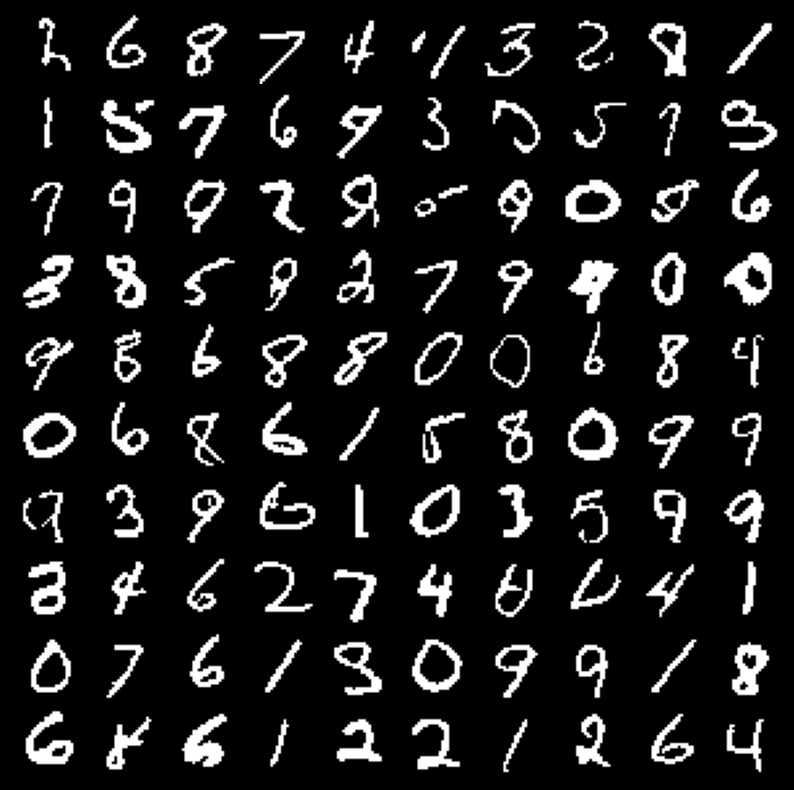

In [16]:
gen_image_batch = model.generate(28, 28, 100, jax.random.key(12))
display_image_grid(gen_image_batch, (10, 10))